# Convolutional Autoencoder for Image Compression and Denoising
- [Introduction](#intro)
- [Part 1: Autoencoder Building](#part1)
- [Part 2: Autoencoder for Image Compression](#part2)
- [Part 3: Autoencoder for Image Denoising](#part3)

<a id='intro'></a>
## Introduction

In this project, I will use Tensorflow to build a convolutional autoencoder, and will show how this neural network can be applied to images from the MNIST dataset to compress and denoise them.

This notebook consists of 3 parts. In Part 1, I will build the neural network. In Parts 2 and 3, I'll show results for image compression and denoising, respectively.

<a id='part1'></a>
## Part 1: Autoencoder Building

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Let's first download the MNIST dataset from the Tensorflow tutorial and have a look at a sample image. The images are already flattened to a 784 pixels vector, and normalized between 0 and 1.

In [3]:
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


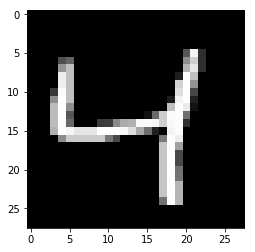

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

Let's build the autoencoder. We will use 3 convolutional+maxpool layers to compress the images, and 3 convolutional+upsampling layers to decode the compressed data and set it back to the original size (28*28 pixels).

In [18]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1], name='targets')

### Compression
conv1 = tf.layers.conv2d(inputs_, 32, (3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='same')
# Now 4x4x16

### Decoding of compressed data
upsample1 = tf.image.resize_nearest_neighbor(encoded, [7, 7])
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3, 3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, [14, 14])
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3, 3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, [28, 28])
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3, 3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3, 3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

<a id='part2'></a>
## Part 2: Autoencoder Training for Image Compression

To train the autoencoder for image compression, we simply need to use the input images as targets:

In [13]:
sess = tf.Session()
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.1178
Epoch: 2/20... Training loss: 0.1058
Epoch: 3/20... Training loss: 0.0971
Epoch: 4/20... Training loss: 0.0918
Epoch: 5/20... Training loss: 0.0886
Epoch: 6/20... Training loss: 0.0887
Epoch: 7/20... Training loss: 0.0874
Epoch: 8/20... Training loss: 0.0858
Epoch: 9/20... Training loss: 0.0880
Epoch: 10/20... Training loss: 0.0816
Epoch: 11/20... Training loss: 0.0822
Epoch: 12/20... Training loss: 0.0834
Epoch: 13/20... Training loss: 0.0824
Epoch: 14/20... Training loss: 0.0815
Epoch: 15/20... Training loss: 0.0804
Epoch: 16/20... Training loss: 0.0790
Epoch: 17/20... Training loss: 0.0807
Epoch: 18/20... Training loss: 0.0805
Epoch: 19/20... Training loss: 0.0782
Epoch: 20/20... Training loss: 0.0789


Let's have a look at the input images and how they look like after passing through the compressing and decompressing convolutional network:

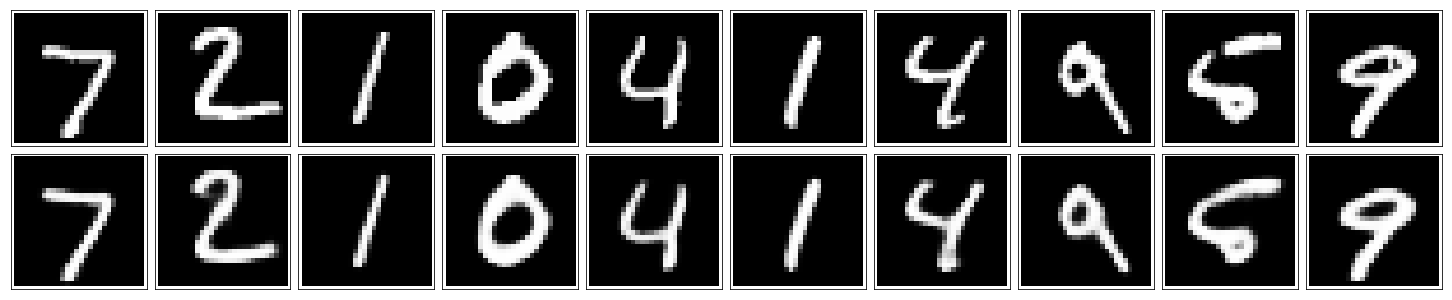

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [15]:
sess.close()

<a id='part3'></a>
## Part 3: Autoencoder Training for Image Denoising

To teach the network to denoise images, we keep the same network architecture, and simply add some random noise to the input images and keep the original images as targets:

In [19]:
sess = tf.Session()
epochs = 20
batch_size = 200
# Set amount of noise added to the images:
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.1712
Epoch: 2/20... Training loss: 0.1408
Epoch: 3/20... Training loss: 0.1366
Epoch: 4/20... Training loss: 0.1307
Epoch: 5/20... Training loss: 0.1251
Epoch: 6/20... Training loss: 0.1218
Epoch: 7/20... Training loss: 0.1178
Epoch: 8/20... Training loss: 0.1195
Epoch: 9/20... Training loss: 0.1141
Epoch: 10/20... Training loss: 0.1128
Epoch: 11/20... Training loss: 0.1125
Epoch: 12/20... Training loss: 0.1066
Epoch: 13/20... Training loss: 0.1072
Epoch: 14/20... Training loss: 0.1120
Epoch: 15/20... Training loss: 0.1143
Epoch: 16/20... Training loss: 0.1109
Epoch: 17/20... Training loss: 0.1089
Epoch: 18/20... Training loss: 0.1057
Epoch: 19/20... Training loss: 0.1053
Epoch: 20/20... Training loss: 0.1039


Let's see the output of the network when we input noisy images:

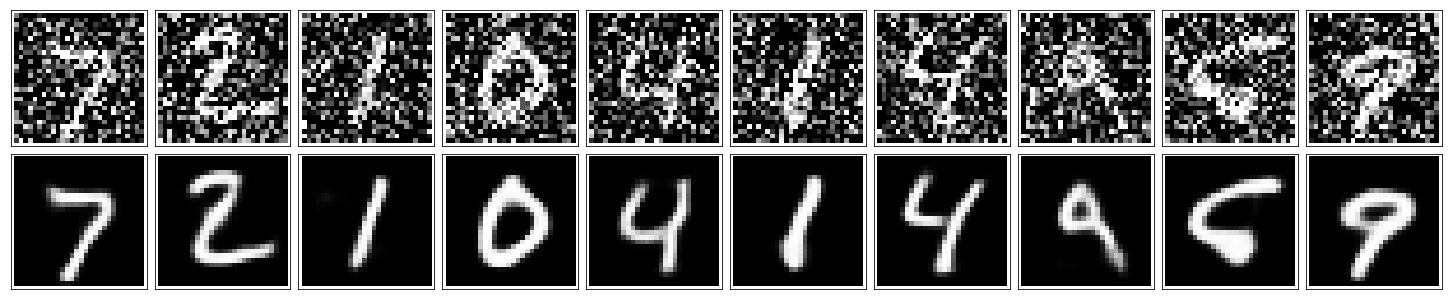

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [21]:
sess.close()